In [67]:
# Import Julia packages
using DrWatson
@quickactivate
using Revise
using LinearAlgebra
using DelimitedFiles
using SparseArrays
using StaticArrays
using BlockArrays
using CairoMakie
using UnPack
using FromFile
using GeometryBasics
using Random
using Colors
using JLD2
using LaTeXStrings
using Glob


@from "$(projectdir())/src/VertexModelContainers.jl" using VertexModelContainers
@from "$(projectdir())/src/Laplacians.jl" using Laplacians
@from "$(projectdir())/src/AnalysisFunctions.jl" using AnalysisFunctions

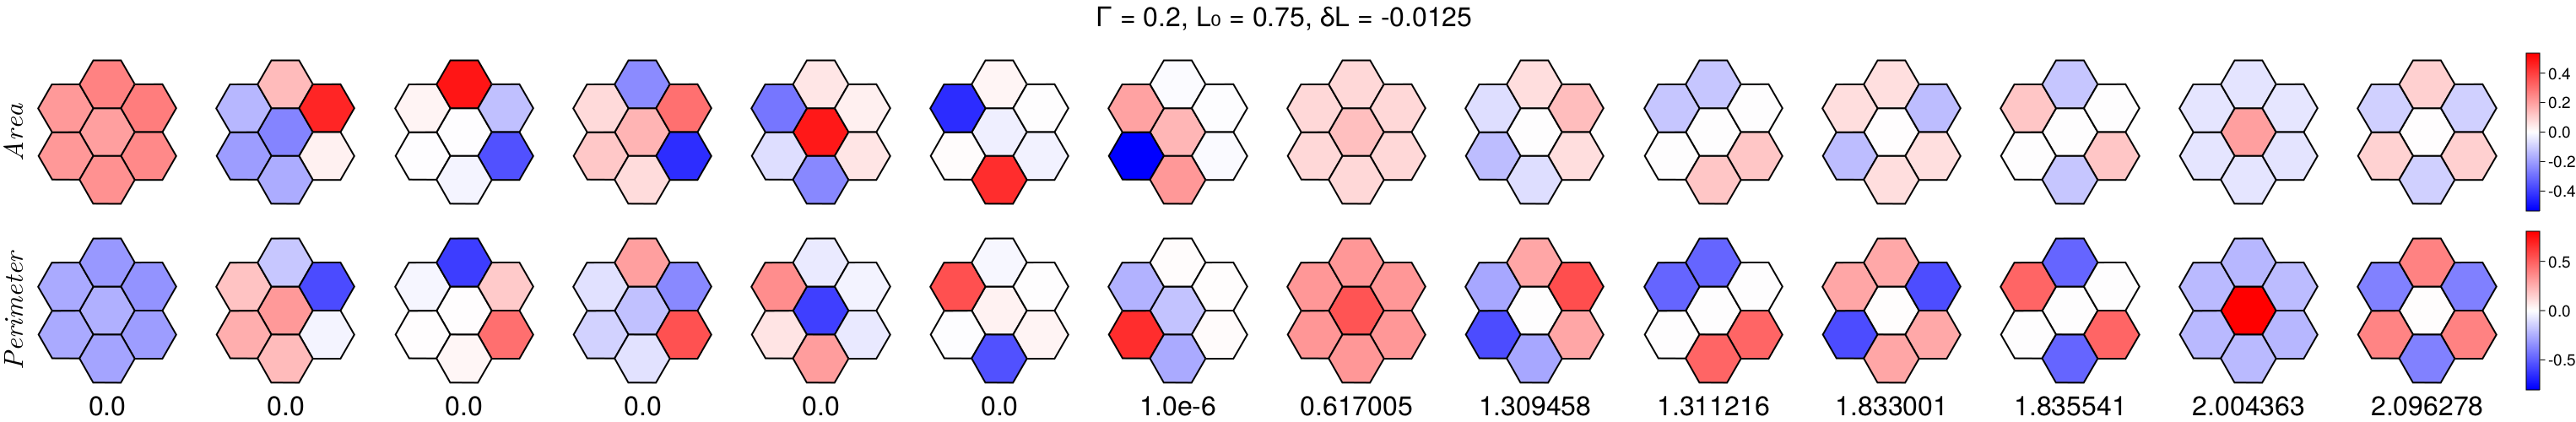

┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605


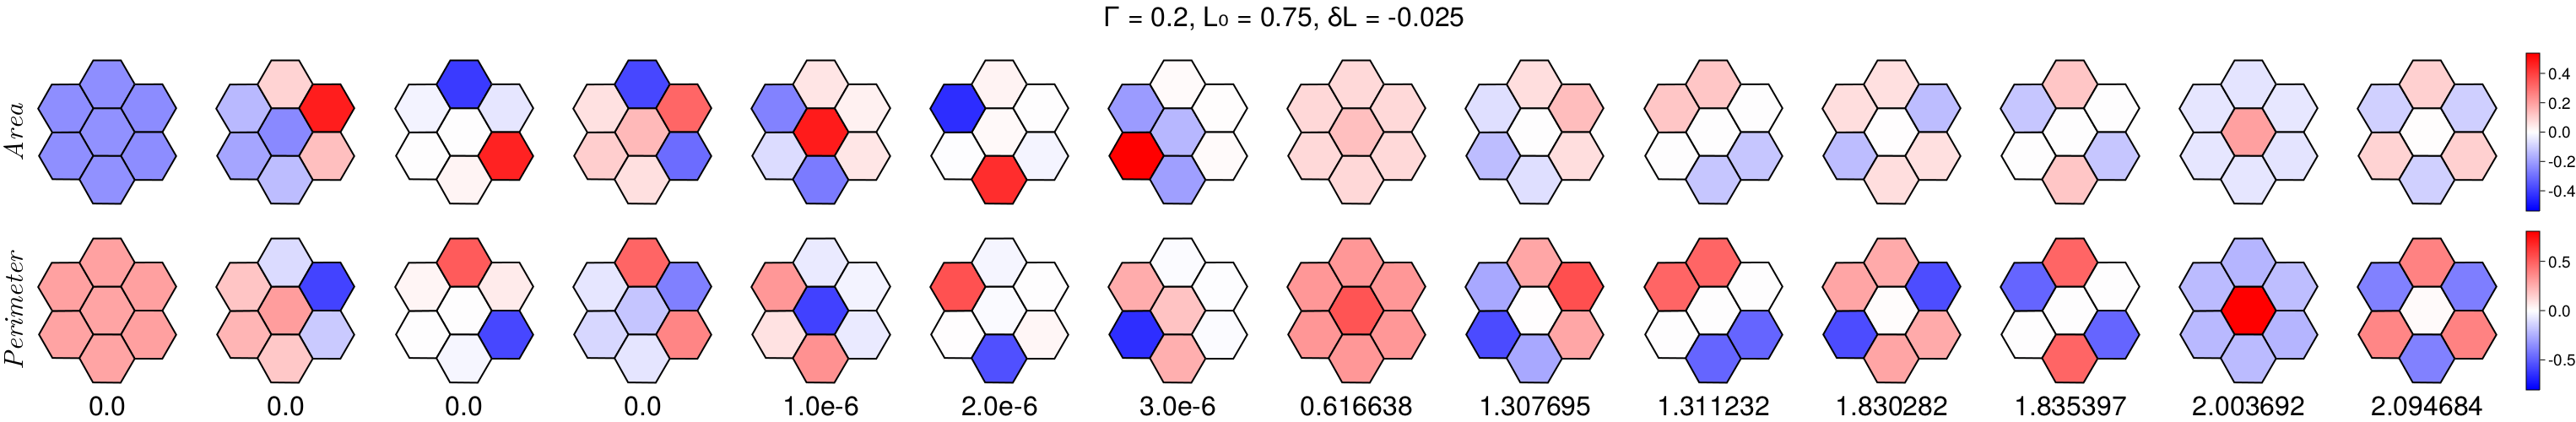

┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605


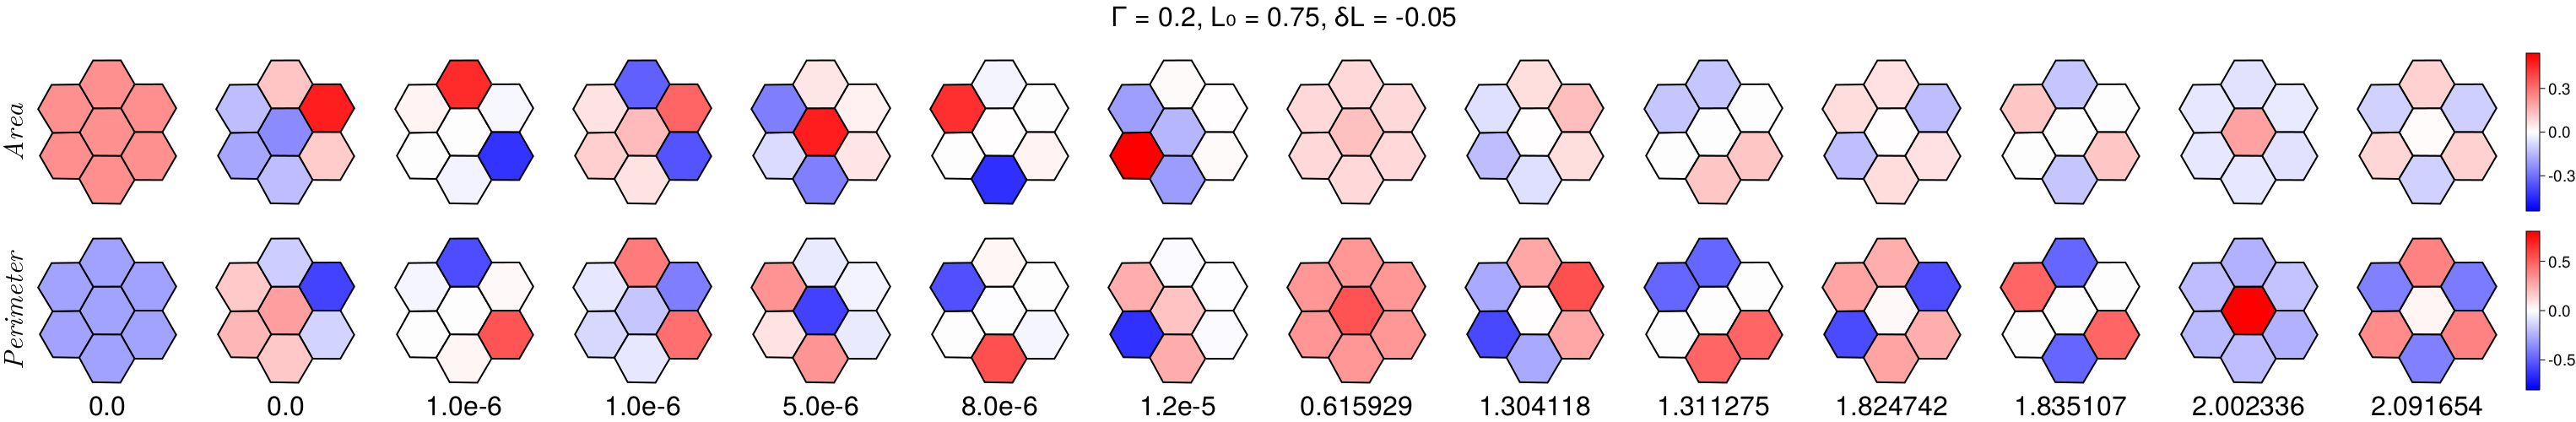

┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605


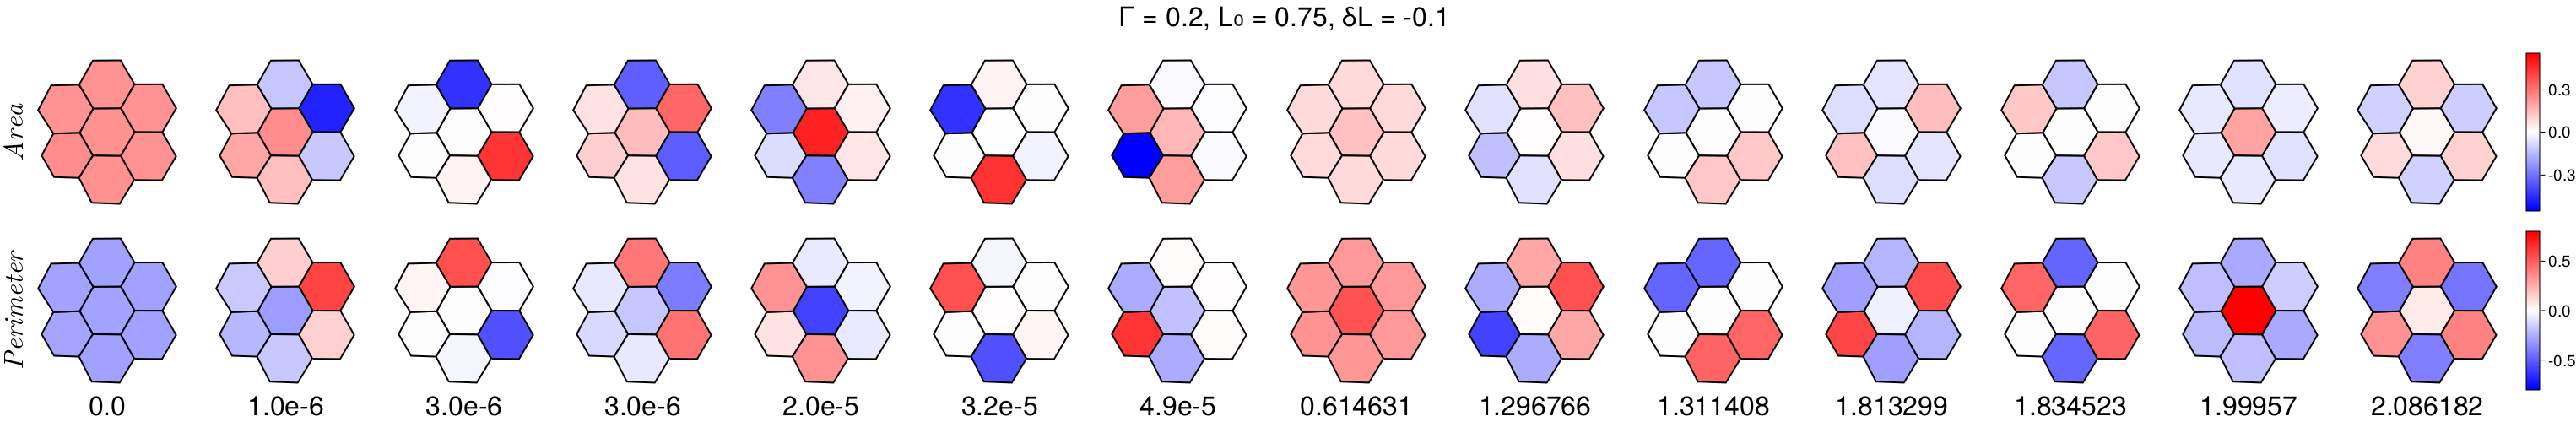

┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605


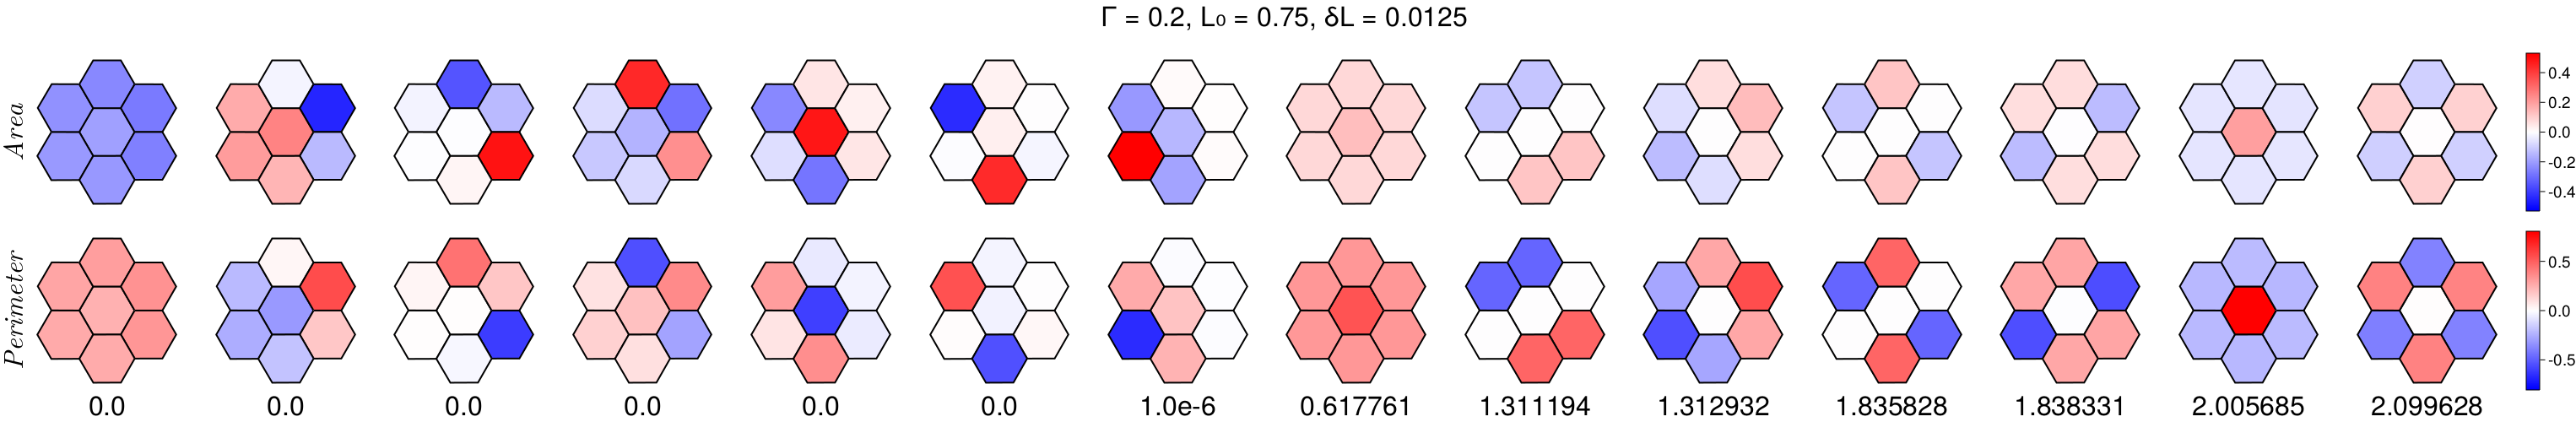

┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605


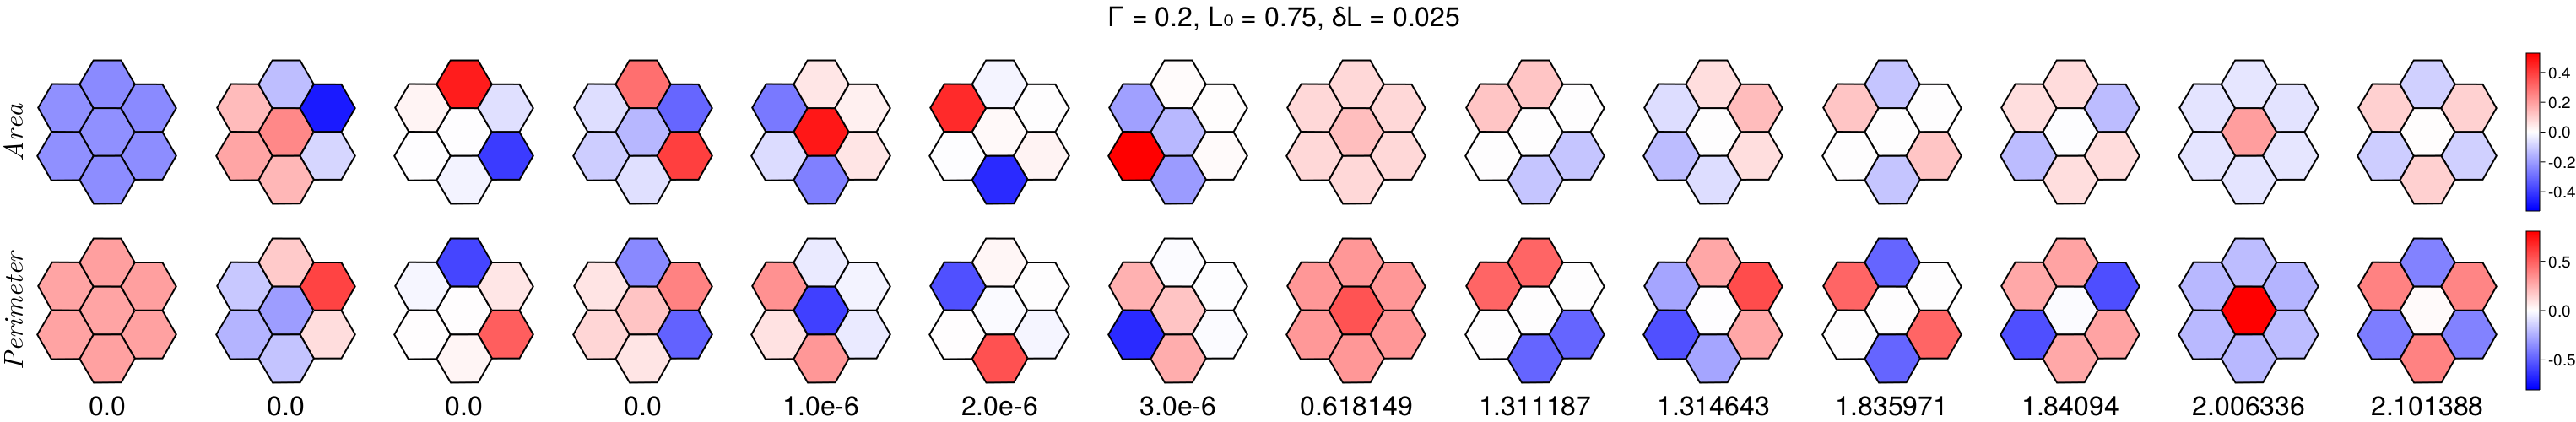

┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605


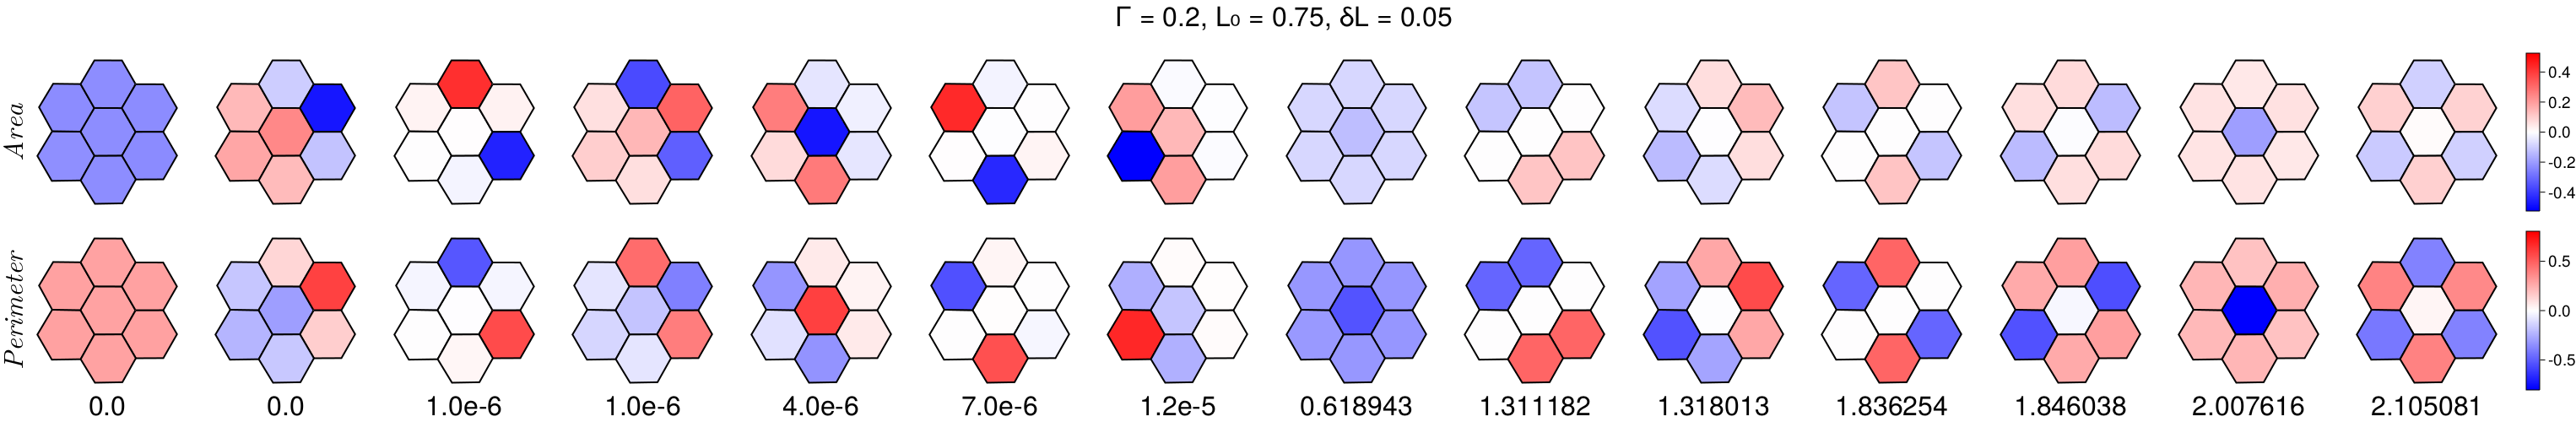

┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605


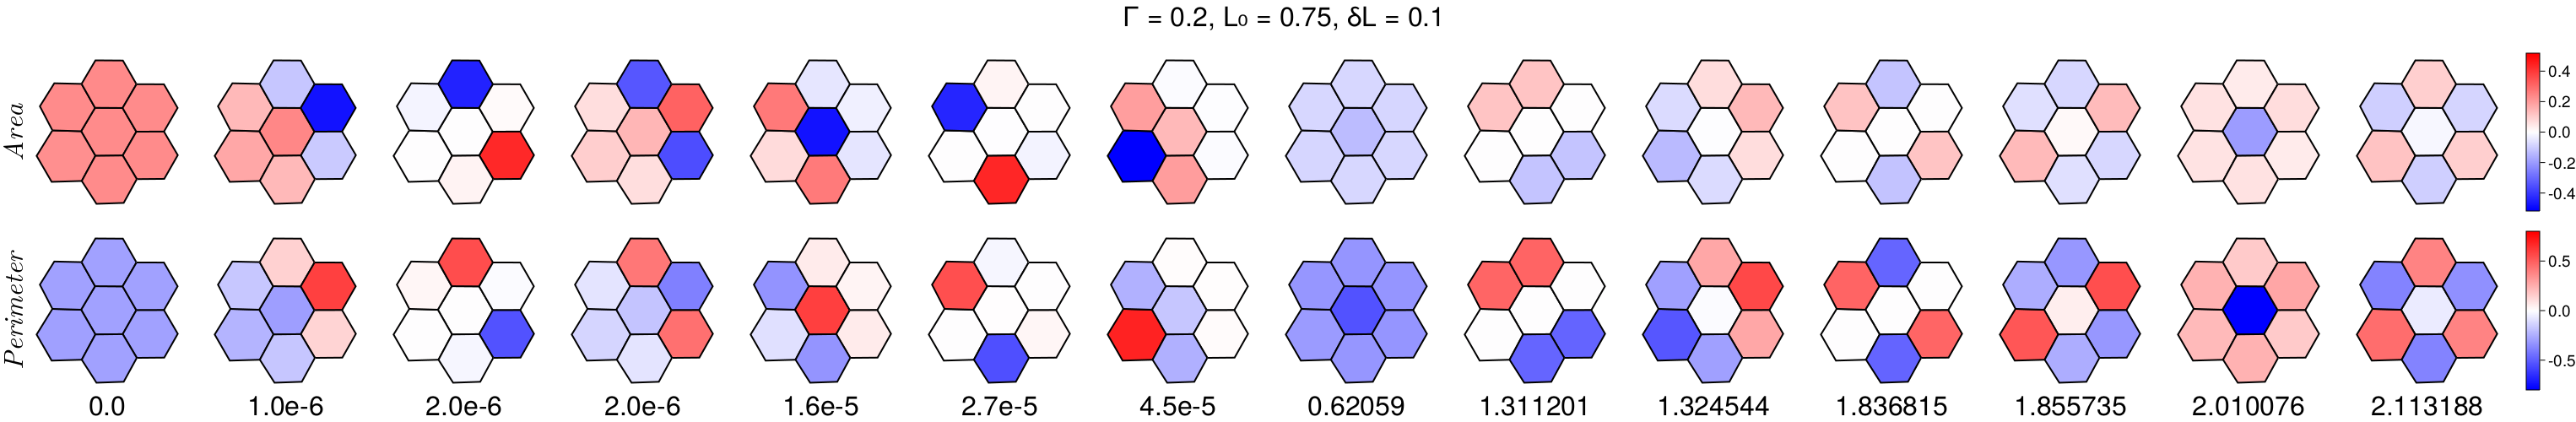

┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605


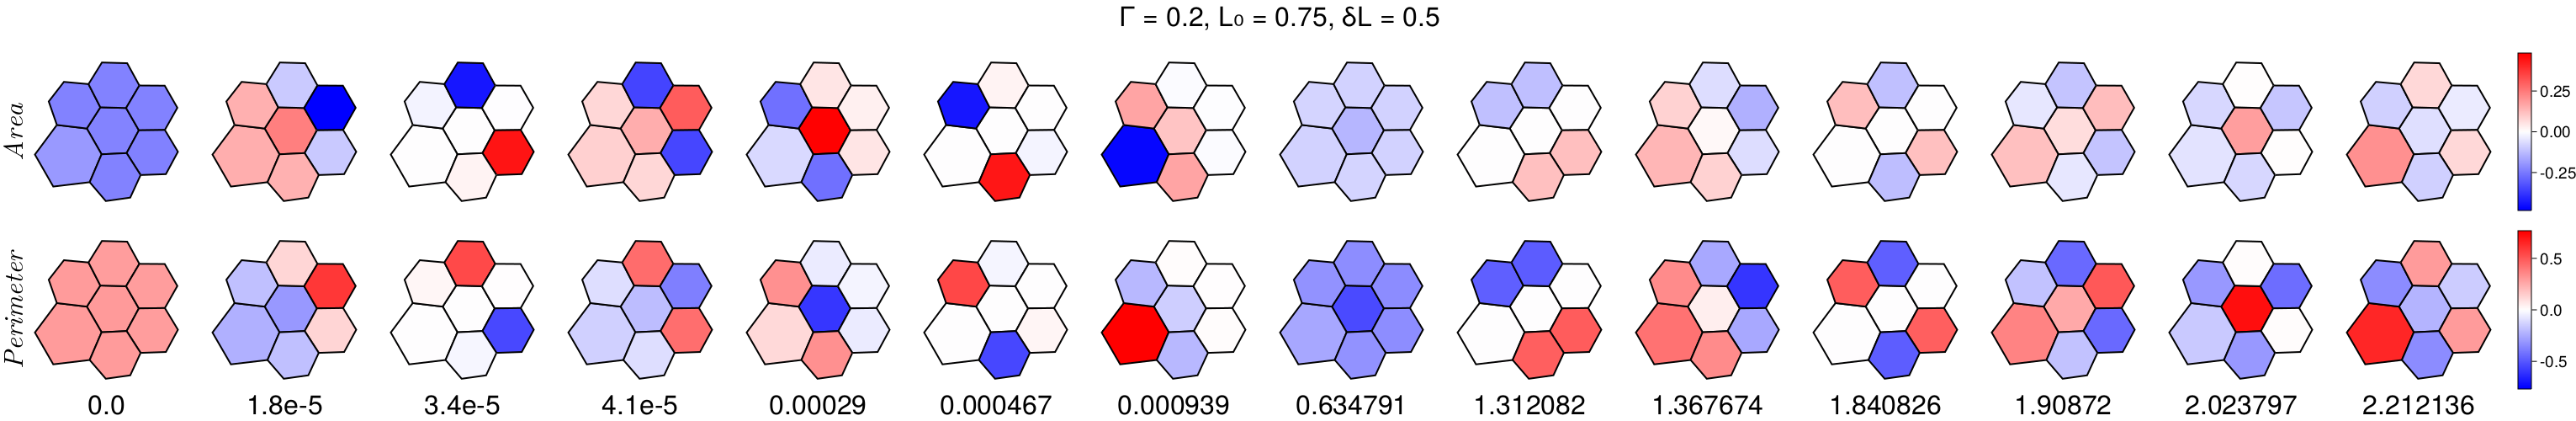

┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605


In [76]:
files=Glob.glob("Seven_cells_edge/*","C:\\Users\\v35431nc\\Documents\\VM_code\\VertexModel\\data\\sims" )
for f in files
    @unpack R, matrices, params = load(datadir(f,"frameData/systemData100.jld2"))
    @unpack B, Bᵀ, C, cellPositions, cellAreas, cellPerimeters = matrices
    @unpack nCells,nVerts = params
    mkpath(datadir(f,"eigenmodes"))

    G=makeG(params)
    M=makeM(matrices)
    Lc=makeEvLc(M)

    emodes=eigen(Matrix(Lc*G))
    evals=real(emodes.values)
    evecs=real(emodes.vectors)
    writedlm(datadir(f,"eigenmodes","eigenvalues_LG.csv"), evals, ',') 
    writedlm(datadir(f,"eigenmodes","eigenvectors_LG.csv"), evecs, ',')  

    Lv=makeEvLv(M, G)
    MTGMem=eigen(Matrix(mortar(Lv)))
    Lvevals=real(MTGMem.values)
    Lvevecs=real(MTGMem.vectors)
    writedlm(datadir(f,"eigenmodes","eigenvalues_MTGM.csv"), Lvevals, ',') 
    writedlm(datadir(f,"eigenmodes","eigenvectors_MTGM.csv"), Lvevecs, ',')  

    cellPolygons = makeCellPolygons(R,params,matrices)

    Aevlims=(-maximum(abs.(evecs[1:nCells,:])), maximum(abs.(evecs[1:nCells, :])))
    Levlims=(-maximum(abs.(evecs[ nCells+1:2*nCells,:])), maximum(abs.(evecs[nCells+1:2*nCells, :])))
    # Set up figure canvas
    set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
    fig = Figure(resolution=(1500,500))
    # grid = fig[1,1] = GridLayout()
    # Cell div axis
    #ax11 = Axis(fig[1,1],aspect=DataAspect())
    for n=1:2*nCells
        a1=Axis(fig[1,n],aspect=DataAspect())
        a2=Axis(fig[2,n],aspect=DataAspect())
        hidedecorations!(a1)
        hidespines!(a1)
        hidedecorations!(a2)
        hidespines!(a2)
        for i=1:nCells
            poly!(a1,cellPolygons[i],color=[evecs[1:nCells,n][i]],colormap=:bwr,colorrange=Aevlims, strokecolor=(:black,1.0),strokewidth=2)
            poly!(a2,cellPolygons[i],color=[evecs[nCells+1:2*nCells,n][i]],colormap=:bwr,colorrange=Levlims, strokecolor=(:black,1.0),strokewidth=2)
        end
        Label(fig[2,n,Bottom()],string(round(evals[n], digits=6)),fontsize = 32)

        #hidedecorations!(ax22)
        #hidespines!(ax22)

        colsize!(fig.layout,n,Aspect(1,1.0))
    end

    Colorbar(fig[1,2*nCells+1],limits=colorrange=Aevlims,colormap=:bwr,flipaxis=true)
    Colorbar(fig[2,2*nCells+1],limits=colorrange=Levlims,colormap=:bwr,flipaxis=true)


    Label(fig[1,1,Left()],string(L"Area"),fontsize = 32, rotation=π/2)
    Label(fig[2,1,Left()],string(L"Perimeter"),fontsize = 32, rotation=π/2)

    #colgap!(fig.layout,1,Relative(0.0))
    #colgap!(fig.layout,2,Relative(0.0))
    #rowgap!(fig.layout,1,Relative(0.01))
    #rowgap!(fig.layout,2,Relative(0.01))


    # boxes = [Box(g,color=(:white,0.0)) for g in [fig[1,1],fig[1,2],fig[1,3],fig[2,1],fig[2,2],fig[2,3],fig[3,1],fig[3,2],fig[3,3]]]
    Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
    resize_to_layout!(fig)

    display(fig)
    save(datadir(f,"eigenmodes","eigenmodes.png"),fig)

end
